# AAAAAAAAAAAAAAAAAnalysis

This notebooks documents the scraping of submissions and comments from the /r/AAAAAAAAAAAAAAAAA subreddit, a subreddit dedicated to.. well.. AAAAAAAAAAAAAAAAA.

The notebook is split into the sections:

1. Scraping data with the pmaw API
2. Cleaning the data to remove uninteresting entries (deleted posts, automoderator comments etc..)
3. Extraction / Engineering of data from the cleaned data
4. Plotting of various quantities from the scraped data

In [280]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pmaw import PushshiftAPI
api = PushshiftAPI()

from sklearn.feature_extraction.text import CountVectorizer

# Data Scraping

Scraping submissions and comments using the pmaw API, mostly following the guidelines here: https://pypi.org/project/pmaw/. Took ~40 minutes to scrape everything.

In [214]:
def scrape_submissions(subreddit, output_csv, limit=1000, before=None, after=None, overwrite_csv=False):
    
    if os.path.exists(output_csv) and not overwrite_csv:
        print("{} Already exists, not overwriting".format(output_csv))
        return
    
    if before and after:
        submissions = api.search_submissions(subreddit=subreddit, limit=limit, before=before, after=after)
    else:
        submissions = api.search_submissions(subreddit=subreddit, limit=limit)

    submission_df = pd.DataFrame(submissions)
    submission_df.to_csv(output_csv, header=True, index=False, columns=list(submission_df.axes[1]))

    print("\nSuccesfully Written {} submissions to {}".format(len(submission_df), output_csv))
    
    
def scrape_comments(subreddit, output_csv, limit=1000, before=None, after=None, overwrite_csv=False):
    
    if os.path.exists(output_csv) and not overwrite_csv:
        print("{} Already exists, not overwriting".format(output_csv))
        return
    
    if before and after:
        comments = api.search_comments(subreddit=subreddit, limit=limit, before=before, after=after)
    else:
        comments = api.search_comments(subreddit=subreddit, limit=limit)

    comments_df = pd.DataFrame(comments)
    comments_df.to_csv(output_csv, header=True, index=False, columns=list(comments_df.axes[1]))

    print("\nSuccesfully Written {} comments to {}".format(len(comments_df), output_csv))

In [215]:
scrape_submissions(subreddit = 'AAAAAAAAAAAAAAAAA', output_csv = 'raw_submissions.csv', limit=None, overwrite_csv=False)
scrape_comments(subreddit = 'AAAAAAAAAAAAAAAAA', output_csv = 'raw_comments.csv', limit=None, overwrite_csv=False)

raw_submissions.csv Already exists, not overwriting
raw_comments.csv Already exists, not overwriting


In [229]:
submissions_df = pd.read_csv('raw_submissions.csv', low_memory=False)
comments_df = pd.read_csv('raw_comments.csv', low_memory=False)

# Ensure created_utc is a datetime object
submissions_df['created_utc'] = pd.to_datetime(submissions_df['created_utc'], unit='s')
comments_df['created_utc'] = pd.to_datetime(comments_df['created_utc'], unit='s')

# Data Cleaning

The raw data we scraped requires some amount of cleaning to remove entries that don't line up with the spirit of the subreddit and or analysis. These will be deleted posts, automoderator posts, and posts from reddit bots (which usually provide some long description of their purpose in their comments).

We will then also filter out urls, subreddit links.

### Filtering Authors

Manually looked at the top 500 posters from each dataframe, we can gauge what authors / usernames to filter out. Showing here the top 6 as a preview of what this step looks for.


These are  '[deleted]', '[removed]', 'AutoModerator' and a list of bots: 'VredditDownloader', 'SaveVideo', 'RepostSleuthBot', 'SaveThisVIdeo', 'sneakpeekbot', 'AutoCrosspostBot', 'CoolDownBot', 'haikusbot', 'MAGIC_EYE_BOT', 'FuckCoolDownBot2', 'FuckThisShitBot41', 'SaveVideo', 'ClickableLinkBot', 'uwutranslator', 'Screem_Bot', 'morse-bot', 'nwordcountbot, 'phonebatterylevelbot', 'SmileBot-2020'

In [230]:
N_FILTER = 10
for v in submissions_df['author'].value_counts()[:N_FILTER].index:
    print(v)
print("")
for v in comments_df['author'].value_counts()[:N_FILTER].index:
    print(v)

[deleted]
fakedimestesso
Mickthebrick1
runningawaywithyrmom
Lansofl
Total-Volume-9387
sindjaika
Catslifephils
hamakaze99
AbundanceLifeStyle

[deleted]
MAGIC_EYE_BOT
runningawaywithyrmom
Mickthebrick1
AutoModerator
VredditDownloader
fakedimestesso
RepostSleuthBot
LonelyGameBoi
billsanzer


In [231]:
# Note, ~ is inverting the .isin mask so we remove posts that match an author in the list
remove_authors = ['[deleted]', '[removed]', 'AutoModerator', 'VredditDownloader', 'SaveVideo', 'RepostSleuthBot', 'SaveThisVIdeo', 'sneakpeekbot', 'AutoCrosspostBot', 'CoolDownBot', 'haikusbot', 'MAGIC_EYE_BOT', 'FuckCoolDownBot2', 'FuckThisShitBot41', 'SaveVideo', 'ClickableLinkBot', 'uwutranslator', 'Screem_Bot', 'morse-bot', 'nwordcountbot', 'phonebatterylevelbot', 'SmileBot-2020']
submissions_df = submissions_df[~submissions_df['author'].isin(remove_authors)]
comments_df = comments_df[~comments_df['author'].isin(remove_authors)]

### Further Filtering

Here I just apply some filterings to tidy up the data we will be analysing (submission titles and comment bodies). Here removing URLs and subreddit/username links.

In [232]:
# Drop any NA values in the raw dataframe
submissions_df = submissions_df.dropna(subset=['title'])
comments_df = comments_df.dropna(subset=['body'])

# remove http and www URLS
# pattern = r'[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
# After trialing multiple regex patterns, this ends up being the simplest way to remove the majority of these posts while retaining time efficiency
submissions_df = submissions_df[submissions_df['title'].str.contains("http")==False]
comments_df = comments_df[comments_df['body'].str.contains("http")==False]

# regex finds and removes subreddit /r/ links
submissions_df['title'] = submissions_df['title'].replace(r'/r/([^\s/]+)', '', regex=True)
comments_df['body'] = comments_df['body'].replace(r'/r/([^\s/]+)', '', regex=True)

# regex finds and removes username /u/ links
submissions_df['title'] = submissions_df['title'].replace(r'/u/([^\s/]+)', '', regex=True)
comments_df['body'] = comments_df['body'].replace(r'/u/([^\s/]+)', '', regex=True)

There are some HTML encodings in the comments like &amp which should be decoded to avoid the countvectorizer catching amp as a word.

In [233]:
def html_decode(s):
    """
    Returns the ASCII decoded version of the given HTML string. This does
    NOT remove normal HTML tags like <p>.
    """
    htmlCodes = (
            ("'", '&#39;'),
            ('"', '&quot;'),
            ('>', '&gt;'),
            ('<', '&lt;'),
            ('&', '&amp;')
        )
    for code in htmlCodes:
        s = s.replace(code[1], code[0])
    return s

submissions_df['title'] = submissions_df['title'].apply(lambda x: html_decode(x))
comments_df['body'] = comments_df['body'].apply(lambda x: html_decode(x))

To filter out some text based emojis that end up comming through, going to remove a few characters '.?!:;-'

In [290]:
def manual_remove(s):
    """
    Returns the ASCII decoded version of the given HTML string. This does
    NOT remove normal HTML tags like <p>.
    """
    replace_chars = ['.','?','!',':',';','-']
    for r in replace_chars:
        s = s.replace(r, '')
    return s

submissions_df['title'] = submissions_df['title'].apply(lambda x: manual_remove(x))
comments_df['body'] = comments_df['body'].apply(lambda x: manual_remove(x))

Finally I will now filter out all characters that are not ASCII valid, maybe this isn't what is wanted ultimately if you actually care to study the small fraction of 'あ' present, but for easier plotting it's preferable to stick to ASCII only.

In [234]:
submissions_df['title'] = submissions_df['title'].apply(lambda x: str(x).encode('ascii', 'ignore').decode('ascii'))
comments_df['body'] = comments_df['body'].apply(lambda x: str(x).encode('ascii', 'ignore').decode('ascii'))

# Feature Engineering

Extraction / Engineering of data from the cleaned data

### Word and Character Frequency

The first data I want to extract is to obtain the frequencies of words and characters within the submission titles and comment bodies. These are then saved into dataframes of key (word or char) and the frequency of the key.

For this we let the sklearn CountVectorizer do most of the parsing.

1. Setting lowercase = False to distringuish case sensitive terms
2. Specifically dropping the space character from the dataframe.

In [292]:
pattern_onlya = re.compile('^[a]+$')
pattern_onlyA = re.compile('^[A]+$')

def summarise_string(in_string, nmax = 50):
    """
    Sometimes we get long strings of a's, this function produces a short description for these long strings
    i.e. 100*'a' yields  "LongString = 100 x a"
    """

    if len(in_string) < nmax:
        return in_string
    
    if re.search(pattern_onlya, in_string):
        number_of_a = len(in_string)
        return "LongString = {} x a".format(number_of_a)
    elif re.search(pattern_onlyA, in_string):
        number_of_a = len(in_string)
        return "LongString = {} x A".format(number_of_a)
    else:
        return in_string
    

def get_count_df(count_vect, training_colum):
    # Run the sklearn countvectorizer
    X_train_counts = count_vect.fit_transform(training_colum)

    # Etract frequencies of the vocabulary
    sum_words = X_train_counts.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in count_vect.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    # Formatting of the dataframes
    output_df = pd.DataFrame(words_freq, columns=["key", "frequency"])
    output_df['key'] = output_df['key'].apply(lambda x: summarise_string(x))
    output_df = output_df[output_df['key'] != ' ']
    
    return output_df

comments_word_df = get_count_df(CountVectorizer(tokenizer=lambda txt: txt.split(), lowercase=False), comments_df['body'])
submissions_word_df = get_count_df(CountVectorizer(tokenizer=lambda txt: txt.split(), lowercase=False), submissions_df['title'])

comments_char_df = get_count_df(CountVectorizer(analyzer='char', lowercase=False), comments_df['body'])
submissions_char_df = get_count_df(CountVectorizer(analyzer='char', lowercase=False), submissions_df['title'])

# Plotting

Now we have the data, let's produce some analysis plots.

### Number of As

Define columns that count the number of a, A, a/A for each row of the dataframe

In [300]:
def count_chars(s,chars):
    total_count = 0
    for c in chars:
        total_count += s.count(c)
    return total_count

def count_notchars(s,chars):
    total_count = 0
    for c in chars:
        total_count += s.count(c)
    return len(s) - total_count

submissions_df['number_a'] = submissions_df['title'].apply(lambda x: count_chars(x, ['a']))
submissions_df['number_A'] = submissions_df['title'].apply(lambda x: count_chars(x, ['A']))
submissions_df['number_aA'] = submissions_df['title'].apply(lambda x: count_chars(x, ['a','A']))
submissions_df['number_not_aA'] = submissions_df['title'].apply(lambda x: count_notchars(x, ['a','A']))

comments_df['number_a'] = comments_df['body'].apply(lambda x: count_chars(x, ['a']))
comments_df['number_A'] = comments_df['body'].apply(lambda x: count_chars(x, ['A']))
comments_df['number_aA'] = comments_df['body'].apply(lambda x: count_chars(x, ['a','A']))
comments_df['number_not_aA'] = comments_df['body'].apply(lambda x: count_notchars(x, ['a','A']))

# 

### A Counts per Week 

Here I have a function that resamples the dataframe values, summing the number of a/A counts for each row across each week. The subreddit began back in 2014 but did not really gain traction until 2018 so the plots have been trimmed to 2017+.

Interestingly large spikes in the comment data for weeks:
- 2019-09-16
- 2020-03-23

Perhaps a copypasta was going around?

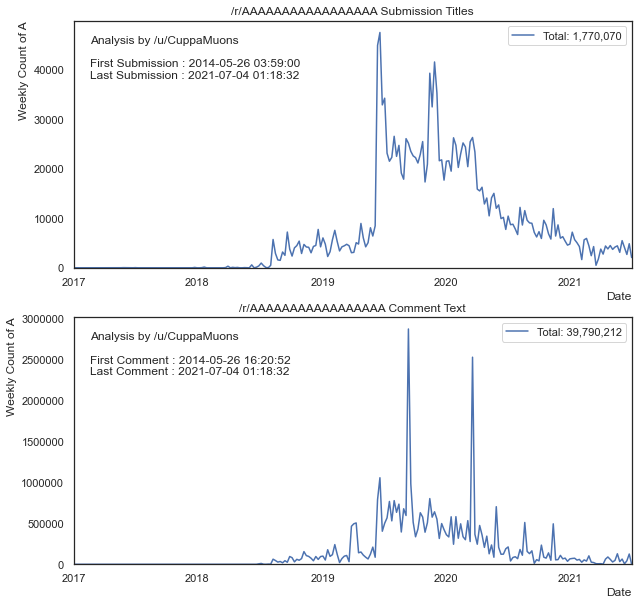

In [442]:
def make_timeplot(submissions_df, comments_df, year_cut=None):
    
    # Resample on Week-Month
    time_submissions_df = submissions_df.resample('W-Mon', on='created_utc')['number_aA'].sum().reset_index().sort_values(by='created_utc')
    time_comments_df = comments_df.resample('W-Mon', on='created_utc')['number_aA'].sum().reset_index().sort_values(by='created_utc')
    
    if year_cut:
        time_submissions_df = time_submissions_df[time_submissions_df['created_utc'].dt.year >= year_cut]
        time_comments_df = time_comments_df[time_comments_df['created_utc'].dt.year >= year_cut]
    
    fig, ax = plt.subplots(2, 1, figsize=(10,10))
    
    time_submissions_df.plot(x='created_utc', y='number_aA', ax=ax[0],  label='Total: {:,}'.format(time_submissions_df['number_aA'].sum()))
    time_comments_df.plot(x='created_utc', y='number_aA', ax=ax[1], label='Total: {:,}'.format(time_comments_df['number_aA'].sum()))
        
    ax[0].set_title('/r/AAAAAAAAAAAAAAAAA Submission Titles')
    ax[0].set_xlabel('Date', loc='right')
    ax[0].set_ylabel('Weekly Count of A', loc='top')

    ax[0].get_yaxis().get_major_formatter().set_scientific(False)
    ax[0].set_ylim(bottom=0)

    ax[0].text(0.03, 0.72, "Analysis by /u/CuppaMuons\n\nFirst Submission : {}\nLast Submission : {}\n".format(submissions_df['created_utc'].min(), submissions_df['created_utc'].max()), transform=ax[0].transAxes)
    
    
    
    ax[1].set_title('/r/AAAAAAAAAAAAAAAAA Comment Text')
    ax[1].set_xlabel('Date', loc='right')
    ax[1].set_ylabel('Weekly Count of A', loc='top')

    ax[1].get_yaxis().get_major_formatter().set_scientific(False)
    ax[1].set_ylim(bottom=0)

    ax[1].text(0.03, 0.72, "Analysis by /u/CuppaMuons\n\nFirst Comment : {}\nLast Comment : {}\n".format(comments_df['created_utc'].min(), submissions_df['created_utc'].max()), transform=ax[1].transAxes)

    plt.savefig('weekly_acount.png', dpi=200)
    plt.show()
    
make_timeplot(submissions_df, comments_df, 2017)

### Most Common Words

Here I show the the 50 most frequently used words in the submissions data and comment data. The results are... not at all surprising. That's a lot of A

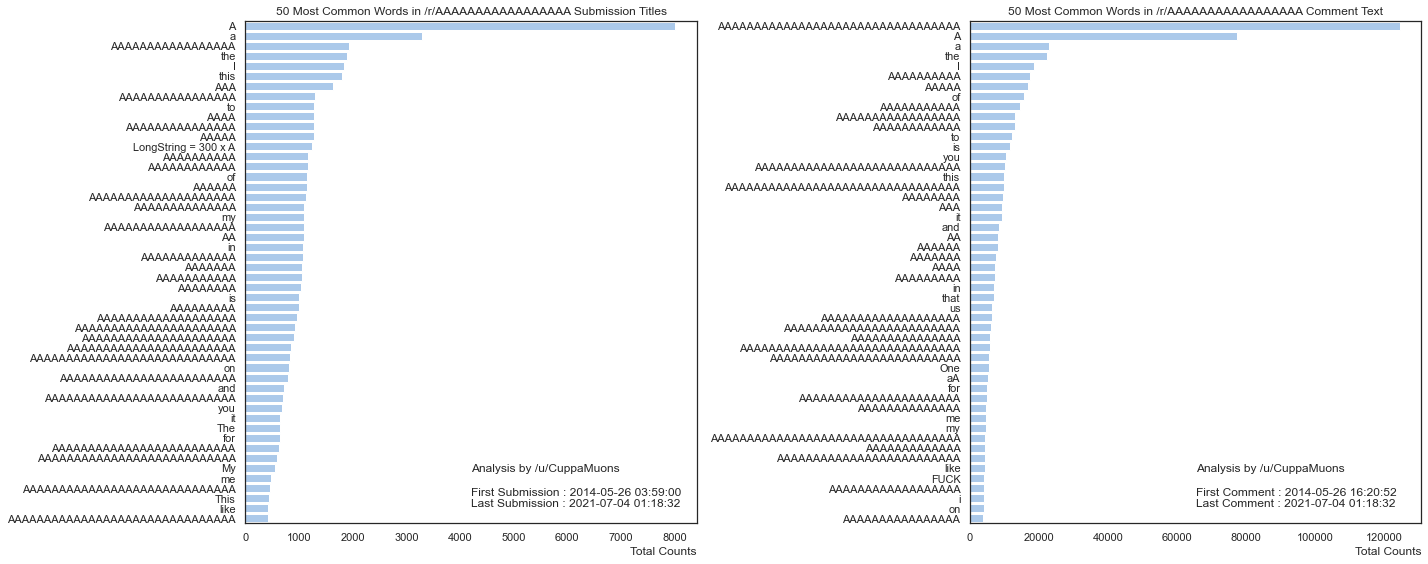

In [438]:
def make_commonplot(submissions_word_df, comments_word_df, limit_n=-1):
    
    sns.set_color_codes("pastel")
    sns.set_style("white")
    fig, ax = plt.subplots(1, 2, figsize=(20,8))

    
    g = sns.barplot(x="frequency", y="key", data=submissions_word_df[:limit_n], color="b", ax=ax[0])
    g = sns.barplot(x="frequency", y="key", data=comments_word_df[:limit_n], color="b", ax=ax[1])
    
    ax[0].set_title('{} Most Common Words in /r/AAAAAAAAAAAAAAAAA Submission Titles'.format(limit_n))
    ax[0].set_xlabel('Total Counts', loc='right')
    ax[0].set_ylabel('', loc='top')

    ax[0].get_xaxis().get_major_formatter().set_scientific(False)

    ax[0].text(0.5, 0.01, "Analysis by /u/CuppaMuons\n\nFirst Submission : {}\nLast Submission : {}\n".format(submissions_df['created_utc'].min(), submissions_df['created_utc'].max()), transform=ax[0].transAxes)
    
    
    ax[1].set_title('{} Most Common Words in /r/AAAAAAAAAAAAAAAAA Comment Text'.format(limit_n))
    ax[1].set_xlabel('Total Counts', loc='right')
    ax[1].set_ylabel('', loc='top')

    ax[1].get_xaxis().get_major_formatter().set_scientific(False)

    ax[1].text(0.5, 0.01, "Analysis by /u/CuppaMuons\n\nFirst Comment : {}\nLast Comment : {}\n".format(comments_df['created_utc'].min(), submissions_df['created_utc'].max()), transform=ax[1].transAxes)

    plt.tight_layout()
    plt.savefig('frequency_plot.png',dpi=200)
    plt.show()
    
make_commonplot(submissions_word_df, comments_word_df, 50)

### Fraction of Characters

Here want to check the fraction of all characters that are A vs those that aren't. Unsurprisingly this is A dominated, but a sizeable 10-20% still remains as other characters.

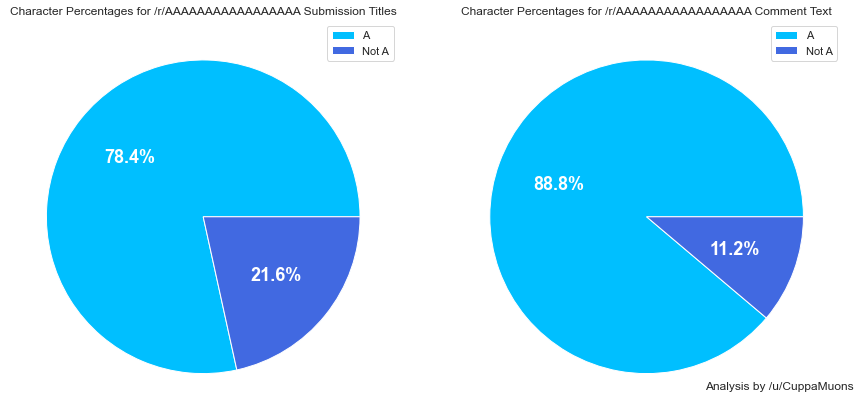

In [444]:
def make_fractionpie(submissions_df, comments_df):
    
    #fig, ax = plt.subplots(1, 2, figsize=(12,12))
    fig, ax = plt.subplots(1, 2, figsize=(13,6))
    labels = ['A', 'Not A']
    colors = ['deepskyblue', 'royalblue']
    
    sizes = [submissions_df['number_aA'].sum(), submissions_df['number_not_aA'].sum()]
    _, _, autotexts = ax[0].pie(sizes, colors=colors, autopct='%1.1f%%', startangle=0)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(18)
        autotext.set_weight('bold')
    
    
    sizes = [comments_df['number_aA'].sum(), comments_df['number_not_aA'].sum()]
    patches, _, autotexts = ax[1].pie(sizes, colors=colors, autopct='%1.1f%%', startangle=0)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(18)
        autotext.set_weight('bold')


    ax[0].set_title('Character Percentages for /r/AAAAAAAAAAAAAAAAA Submission Titles')
        
    ax[1].set_title('Character Percentages for /r/AAAAAAAAAAAAAAAAA Comment Text')


    ax[1].text(0.65, 0.06, "Analysis by /u/CuppaMuons".format(comments_df['created_utc'].min(), submissions_df['created_utc'].max()), transform=ax[1].transAxes)
    
    ax[0].legend(patches, labels, loc="best")
    ax[1].legend(patches, labels, loc="upper right")
    plt.tight_layout()
    plt.savefig('fractionpie_plot.png', dpi=200)
    plt.show()
    
make_fractionpie(submissions_df, comments_df)

# Conclusion

1. AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

2. AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA 

3. AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA.